In [98]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import pickle

In [99]:
X = pd.read_csv('training_set_values.csv', index_col = 0)

In [100]:
y = pd.read_csv('training_set_labels.csv', index_col = 0)

In [101]:
df = pd.concat([X, y], axis = 1)

In [102]:
classes = ['functional', 'functional needs repair', 'non functional']

#### remove: wpt_name, date_recorded, region_code, recorded_by, scheme_name, extraction_type, payment_type, water_quality, quantity_group, source

#### possibly to remove: funder, long/lat, num_private, installer, subvillage

#### Maybe: district_code, lga, ward, scheme_management/management, extraction_type_group, management_group

#### Dummies: Basin, region, public_meeting, permit, extraction_type_class, payment, quality_group, quantity, source_type, source_class, waterpoint_type_group

#### Continuous: amount_tsh, gps_height, population, construction_year (look at 0's)

In [103]:
df.drop(columns = ['wpt_name', 'date_recorded', 'region_code', 'recorded_by', 
                     'scheme_name', 'extraction_type', 'payment_type', 'water_quality', 
                     'quantity_group', 'source', 'waterpoint_type'], inplace = True)

In [104]:
df2 = df.drop(columns = ['funder', 'longitude', 'latitude', 'num_private', 
                         'installer', 'subvillage'])

In [105]:
df3 = df2.drop(columns = ['district_code', 'lga', 'ward', 'scheme_management', 'management', 
                          'extraction_type_group', 'management_group', 'construction_year'])

In [9]:
df3.dropna(inplace = True)

## Making Dummies

In [106]:
basin_dummies = pd.get_dummies(df3['basin'], prefix = 'basin_', drop_first = True)

region_dummies = pd.get_dummies(df3['region'], prefix = 'region_', drop_first = True)

extraction_dummies = pd.get_dummies(df3['extraction_type_class'], prefix = 'extraction_', 
                                    drop_first = True)

payment_dummies = pd.get_dummies(df3['payment'], prefix = 'payment_', drop_first = True)

quality_dummies = pd.get_dummies(df3['quality_group'], prefix = 'quality_', drop_first = True)

quantity_dummies = pd.get_dummies(df3['quantity'], prefix = 'quantity_', drop_first = True)

source_type_dummies = pd.get_dummies(df3['source_type'], prefix = 'source_type', 
                                     drop_first = True)

source_class_dummies = pd.get_dummies(df3['source_class'], prefix = 'source_class', 
                                      drop_first = True)

waterpoint_type_dummies = pd.get_dummies(df3['waterpoint_type_group'], prefix = 'waterpoint_type_',
                                       drop_first = True)

In [107]:
permit_dict = {True: 1,
               False: 0}

df3[['permit', 'public_meeting']] = df3[['permit', 'public_meeting']].replace(permit_dict)

In [108]:
status_dict = {'functional': 1, 
               'non functional': 0, 
               'functional needs repair': 2}

In [109]:
df3 = pd.concat([df3, waterpoint_type_dummies, source_class_dummies, source_type_dummies,
                basin_dummies, region_dummies, extraction_dummies, payment_dummies,
                quality_dummies, quantity_dummies], axis = 1)

In [110]:
df3.drop(columns = ['basin', 'region', 'extraction_type_class', 'payment', 'quality_group', 
                    'quantity', 'source_type', 'source_class', 'waterpoint_type_group'], inplace = True)

In [66]:
df3.shape

(53281, 68)

In [111]:
X3 = df3.drop(columns = ['status_group'], axis = 1)

In [112]:
y3 = df3['status_group']

In [18]:
y3.unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

## Basic_Model

In [113]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=23)

In [114]:
scaler3 = StandardScaler()
scaler3.fit(X3_train)
X3_train = pd.DataFrame(data=scaler3.transform(X3_train), columns = X3.columns)
X3_test = pd.DataFrame(data=scaler3.transform(X3_test), columns = X3.columns)

(39960, 67)

## KNN Model (Basic Set #1)

In [115]:
knn_df3 = KNeighborsClassifier()

In [116]:
knn_df3.fit(X3_train, y3_train)

y_pred_knn3 = knn_df3.predict(X3_test)
y_train_knn3 = knn_df3.predict(X3_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [117]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_knn3))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_knn3))

ValueError: Found input variables with inconsistent numbers of samples: [14850, 13321]

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[6091  222  880]
 [ 581  247  145]
 [1423  113 3619]]


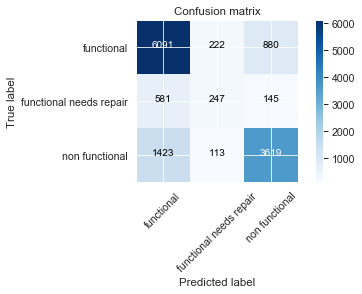

In [25]:
plot_confusion_matrix(metrics.confusion_matrix(y3_test, y_pred_knn3), classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Random Forest (Best set #2)

In [37]:
rfc_df3 = RandomForestClassifier(class_weight='balanced', criterion = 'entropy', max_depth = 16, 
                                 n_estimators = 200, random_state = 23, n_jobs = -1)

In [38]:
rfc_df3.fit(X3_train, y3_train)

y_pred_rfc3 = rfc_df3.predict(X3_test)
y_train_rfc3 = rfc_df3.predict(X3_train)

In [39]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_rfc3))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_rfc3))

Test Accuracy score:  0.7239696719465506
Train Accuracy score:  0.7985235235235235


### Random Forest Gridsearch 

In [29]:
params_df3 = {'max_depth': [3, 6, 9, 12, 15], 'n_estimators' : [100, 200, 300, 400, 500], 
              'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 
              'criterion': ['gini', 'entropy']} 

In [30]:
grid_df3 = GridSearchCV(rfc_df3, params_df3, verbose = 1, n_jobs = -1, cv = 5, scoring = 'accuracy')

grid_df3.fit(X3_train, y3_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s


KeyboardInterrupt: 

In [ ]:
grid_df3.best_estimator_

## XGB Model 

In [120]:
xgb_df3 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [122]:
xgb_df3.fit(X3_train, y3_train)

y_pred_xgb3 = xgb_df3.predict(X3_test)

y_train_xgb3 = xgb_df3.predict(X3_train)

In [123]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_xgb3))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_xgb3))

Test Accuracy score:  0.7812794612794612
Train Accuracy score:  0.8483950617283951


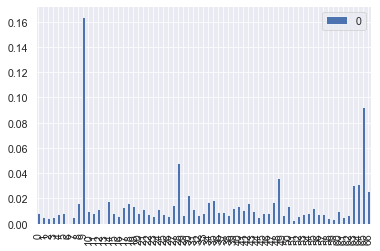

In [179]:
pd.DataFrame(xgb_df3.feature_importances_).plot.bar()

Index(['amount_tsh', 'gps_height', 'population', 'public_meeting', 'permit',
       'waterpoint_type__communal standpipe', 'waterpoint_type__dam',
       'waterpoint_type__hand pump', 'waterpoint_type__improved spring',
       'waterpoint_type__other', 'source_class_surface',
       'source_class_unknown', 'source_type_dam', 'source_type_other',
       'source_type_rainwater harvesting', 'source_type_river/lake',
       'source_type_shallow well', 'source_type_spring', 'basin__Lake Nyasa',
       'basin__Lake Rukwa', 'basin__Lake Tanganyika', 'basin__Lake Victoria',
       'basin__Pangani', 'basin__Rufiji', 'basin__Ruvuma / Southern Coast',
       'basin__Wami / Ruvu', 'region__Dar es Salaam', 'region__Dodoma',
       'region__Iringa', 'region__Kagera', 'region__Kigoma',
       'region__Kilimanjaro', 'region__Lindi', 'region__Manyara',
       'region__Mara', 'region__Mbeya', 'region__Morogoro', 'region__Mtwara',
       'region__Mwanza', 'region__Pwani', 'region__Rukwa', 'region__Ruvuma

## XGB Gridsearch

In [49]:
param_xgb = {'max_depth' : [4, 6, 8, 10], 'learning_rate' : [.01, .05, .1, .2], 
             'n_estimators' : [100, 250, 500], 'min_child_weight' : [1,3,5]}

In [51]:
grid_xgb = GridSearchCV(xgb_df3, param_xgb, n_jobs = -1, cv = 3, verbose = 1)

grid_xgb.fit(X3_train, y3_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 182.7min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=23,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, val

In [97]:
grid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=23, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [55]:
y_pred_xgb_grid = grid_xgb.best_estimator_.predict(X3_test)

In [57]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_xgb_grid))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_xgb3))

Test Accuracy score:  0.7781698070715412
Train Accuracy score:  0.8236486486486486


Confusion Matrix, without normalization
[[6444  141  608]
 [ 619  215  139]
 [1394   54 3707]]


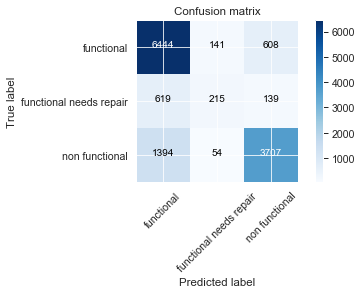

In [58]:
plot_confusion_matrix(metrics.confusion_matrix(y3_test, y_pred_xgb_grid), classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [150]:
test_df = pd.read_csv('Test_set_values.csv', index_col = 0)

In [151]:
basin_dummies = pd.get_dummies(test_df['basin'], prefix = 'basin_', drop_first = True)

region_dummies = pd.get_dummies(test_df['region'], prefix = 'region_', drop_first = True)

extraction_dummies = pd.get_dummies(test_df['extraction_type_class'], prefix = 'extraction_', 
                                    drop_first = True)

payment_dummies = pd.get_dummies(test_df['payment'], prefix = 'payment_', drop_first = True)

quality_dummies = pd.get_dummies(test_df['quality_group'], prefix = 'quality_', drop_first = True)

quantity_dummies = pd.get_dummies(test_df['quantity'], prefix = 'quantity_', drop_first = True)

source_type_dummies = pd.get_dummies(test_df['source_type'], prefix = 'source_type', 
                                     drop_first = True)

source_class_dummies = pd.get_dummies(test_df['source_class'], prefix = 'source_class', 
                                      drop_first = True)

waterpoint_type_dummies = pd.get_dummies(test_df['waterpoint_type_group'], prefix = 'waterpoint_type_',
                                       drop_first = True)

permit_dict = {True: 1,
               False: 0}

test_df[['permit', 'public_meeting']] = test_df[['permit', 'public_meeting']].replace(permit_dict)

test_df = pd.concat([test_df, waterpoint_type_dummies, source_class_dummies, source_type_dummies,
                basin_dummies, region_dummies, extraction_dummies, payment_dummies,
                quality_dummies, quantity_dummies], axis = 1)

test_df.drop(columns = ['wpt_name', 'date_recorded', 'region_code', 'recorded_by', 
                   'scheme_name', 'extraction_type', 'payment_type', 'water_quality', 
                   'quantity_group', 'source', 'waterpoint_type', 'funder', 'longitude', 
                   'latitude', 'num_private', 'installer', 'subvillage', 'district_code', 
                   'lga', 'ward', 'scheme_management', 'management', 'extraction_type_group', 
                   'management_group', 'construction_year', 'basin', 'region', 
                   'extraction_type_class', 'payment', 'quality_group', 'quantity', 
                   'source_type', 'source_class', 'waterpoint_type_group'], inplace = True)



In [157]:
id_df = test_df.reset_index()['id']

In [163]:
test_df = pd.DataFrame(data=scaler3.transform(test_df), columns = test_df.columns)

In [164]:
test_results = xgb_df3.predict(test_df)

In [165]:
testing_results = pd.DataFrame(test_results, columns = ['status_group'])

functional                 9436
non functional             4984
functional needs repair     430
Name: status_group, dtype: int64

In [171]:
test_labels = pd.concat([id_df, testing_results], axis = 1)

In [172]:
test_labels = test_labels.set_index('id')

In [175]:
test_labels

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
...,...
39307,non functional
18990,functional
28749,functional


In [174]:
test_labels.to_csv('testing_results.csv')